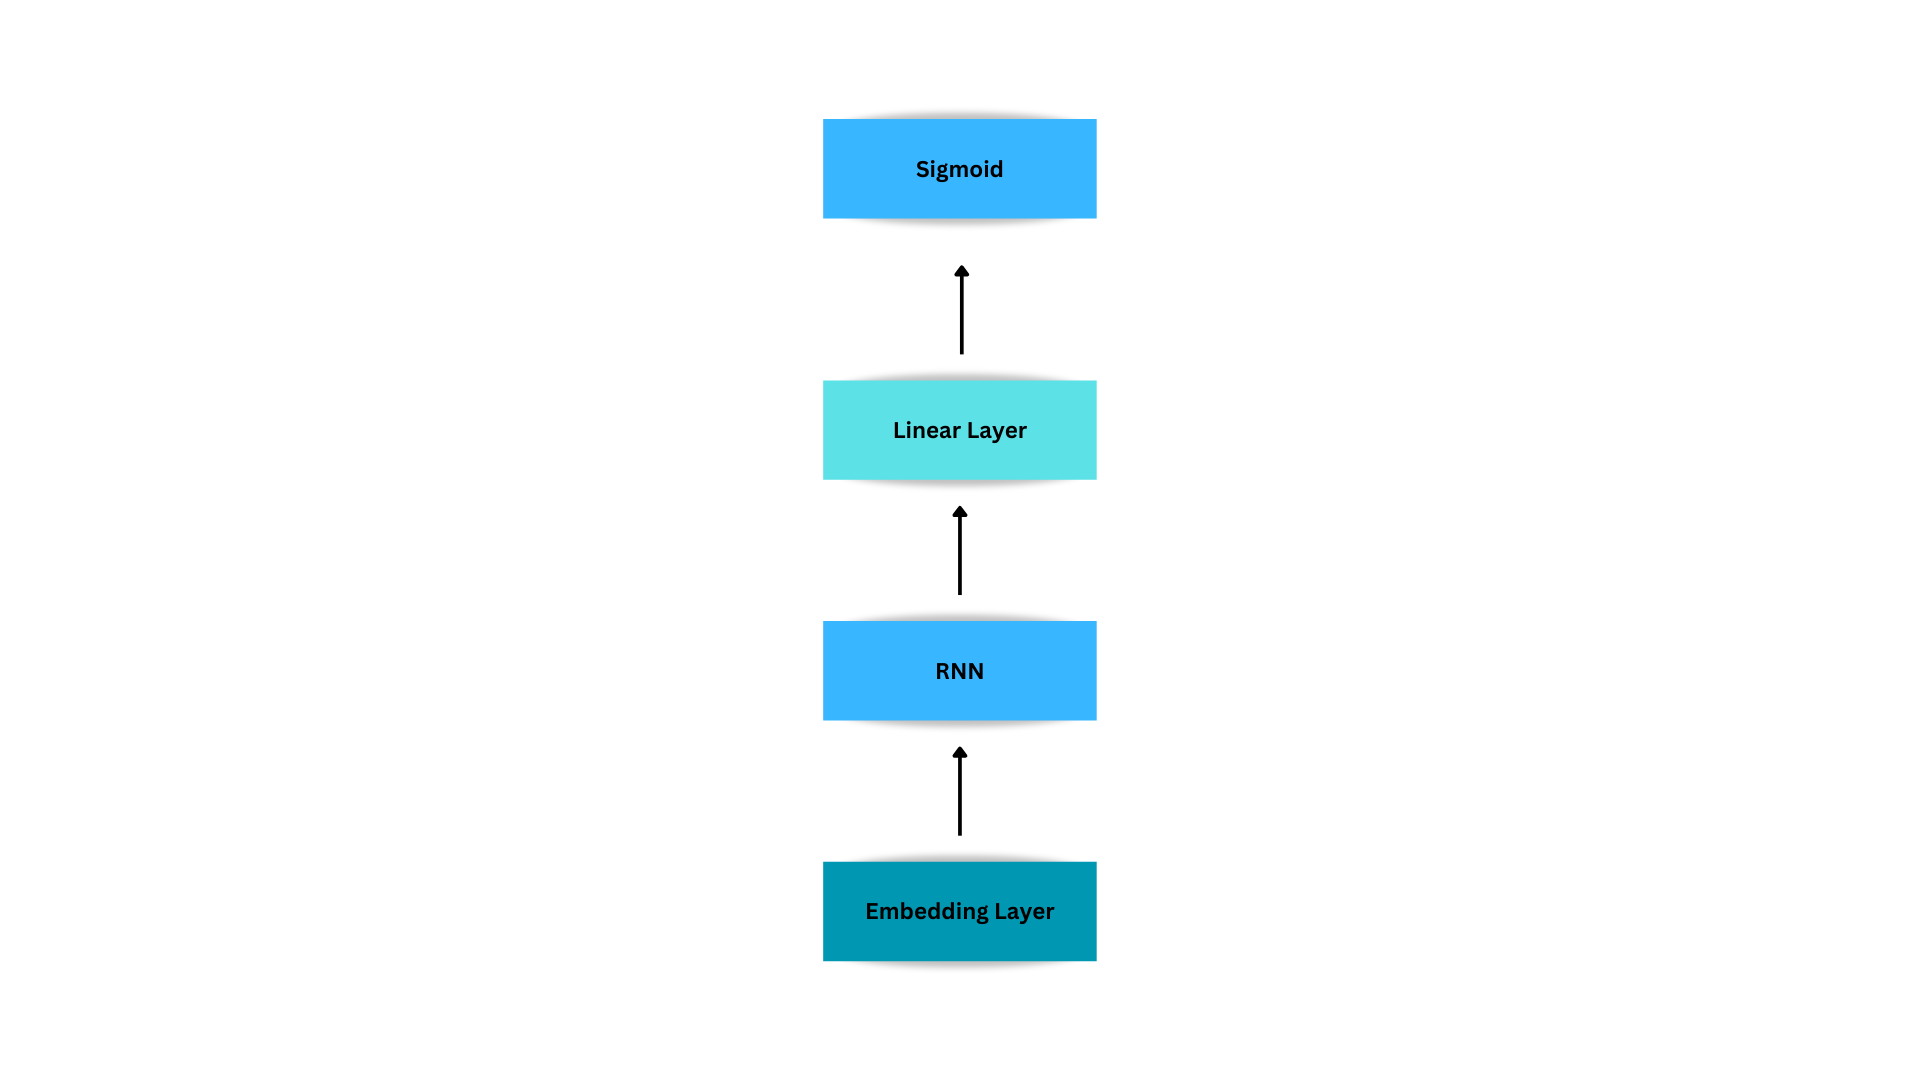

In [1]:
%matplotlib inline
from IPython.display import Image
Image('RNN structre (1).png')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import tkseem as tk
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split


# Cleaning data

In [3]:
import emoji
import re
import pandas as pd
df = pd.read_csv('archive (1)\Arabic Sentiment Analysis Dataset - SS2030.csv')


def remove_english_char(df):
    
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+|"
        r"[A-Za-z.@:()\n/_[0-9]", flags=re.UNICODE)

    df['text'] = df['text'].apply(lambda x: emoji_pattern.sub(r'', str(x)))
    return df


df = remove_english_char(df)


# Splitting the data

In [4]:

X = df['text']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
df.head()

,text,Sentiment
0,حقوق المرأة,1
1,حقوق المرأة في الإسلام,1
2,لجنة التنمية بشبرا ما زال التسجيل مستمر ف...,1
3,حقوق المرأة التي تضمنها لها وزارة العدل,1
4,ولي امر الزوجة او ولي الزوجة او ولي المراة م...,1


# tokenizing 

In [6]:
def simple_tokenizer(txt):
    stripped_text = txt.strip()
    tokens = re.findall(r'\b\w+\b', stripped_text)
    return tokens

train_tokens = []
for text in X_train:
    train_tokens.extend(simple_tokenizer(text))


In [ ]:
train_tokens

# Mapping

In [8]:
int2word = dict(enumerate(train_tokens))
word2int = {char: ind for ind, char in int2word.items()}


In [9]:
int2word[0]

'اللة'

In [10]:
word2int['اللة']

0

# Encoding the data

In [11]:
encoded_train = []
for i, word in enumerate(train_tokens):
    encoded_train.append(i)

In [12]:
len(encoded_train),len(word2int)

(73118, 21172)

In [ ]:
text_ints = []
for txt in X_train:
    # txt=txt.split()
    tokens = re.findall(r'\b\w+\b', txt)
    print(tokens)
    text_ints.append([word2int[word] for word in tokens])  # Convert each word to its integer representation


In [ ]:
text_ints[:2]

In [17]:
len(text_ints)

3401

In [18]:
vocab = len(text_ints)
vocab

3401

In [19]:
maxlen = len(max(text_ints, key=len))
print("The longest string has {} characters".format(maxlen))

The longest string has 78 characters


In [42]:
class MyRNN(nn.Module):
    def __init__(self, hidden_size, n_layers, no_embedding, embedding_dim):
        super(MyRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.no_embedding = no_embedding
        self.embedding_dim = embedding_dim
        
        # Layers 
        self.embd = nn.Embedding(no_embedding, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers)  # 
        self.fc = nn.Linear(hidden_size, 2)   
        
    def forward(self, sentence):
        emb = self.embd(sentence)
        out, _ = self.rnn(emb)
        fc = self.fc(out)
        out = torch.sigmoid(fc)
        return out



In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [44]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# text_ints = label_encoder.fit_transform(text_ints)
y_train = label_encoder.fit_transform(y_train)


In [45]:
text_int_tensors = [torch.tensor(txt, dtype=torch.long) for txt in text_ints]
type(text_int_tensors)

list

In [46]:

input_train = pad_sequence(text_int_tensors, batch_first=True)
target_train = torch.as_tensor(y_train)

In [47]:
target_train

tensor([1, 0, 0,  ..., 0, 0, 0])

In [48]:
max_index = input_train.max()
print(f'Maximum index in input data: {max_index.item()}')
# Make sure this number is less than num_embeddings in your RNN's embedding layer
no_embedding = max_index.item() + 1  #  Add 1 since idx start from 0


Maximum index in input data: 73117


In [49]:
input_train.size() , target_train.size()

(torch.Size([3401, 78]), torch.Size([3401]))

# RNN parameters

In [62]:
RNN = MyRNN(2,200,no_embedding,vocab)
learning_rate = 0.0005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(RNN.parameters(), lr=learning_rate)
RNN.to(device)

MyRNN(
  (embd): Embedding(73118, 3401)
  (rnn): RNN(3401, 2, num_layers=200)
  (fc): Linear(in_features=2, out_features=2, bias=True)
)

# Data Loader

In [63]:
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(input_train, target_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [64]:
epochs = 5

# Training loop
for epoch in range(epochs):
    RNN.train()  
    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  
        
        optimizer.zero_grad()
        outputs = RNN(inputs)
        last_outputs = outputs[:, -1, :]
        loss = criterion(last_outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {average_loss}')


Epoch 1/5, Loss: 0.6904634242859956
Epoch 2/5, Loss: 0.6882003796434848
Epoch 3/5, Loss: 0.6866372623176218
Epoch 4/5, Loss: 0.6856774971863934
Epoch 5/5, Loss: 0.684753590655104


In [65]:
X_test = label_encoder.fit_transform(X_test)
y_test = label_encoder.fit_transform(y_test)


In [66]:
test_X_tensor = torch.tensor(X_test.tolist(), dtype=torch.long)
test_y_tensor = torch.tensor(y_test.tolist(), dtype=torch.long)
test_dataset = TensorDataset(test_X_tensor, test_y_tensor)


In [67]:
RNN.eval()
correct_predictions = 0

with torch.no_grad():
    for i in range(len(test_dataset)):
        inputs, labels = test_dataset[i]
        outputs = RNN(inputs.unsqueeze(0))
        predicted = torch.argmax(outputs).item()

        if predicted == labels.item():
            correct_predictions += 1

accuracy = correct_predictions / len(test_dataset)
print(f'Testing - Accuracy: {accuracy * 100:.2f}%')


Testing - Accuracy: 58.99%
